# Inital setup

In [1]:
import time

import torch 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import resnet as rnet

import matplotlib.pyplot as plt
import numpy as np

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"using device {device}")

path = "./"

using device cuda:0


### Help functions

In [2]:
def validateFunc(model, val_loader, batches):
    valacc = []
    
    model.eval()

    for i, (images, targets) in enumerate(val_loader):
        if i >= batches:
            break
        if cuda_available: 
            images = images.cuda()
            targets = targets.cuda()

        t = time.time()
        prediction = model.forward(images)

        valacc = valacc + [get_xent_acc(prediction, targets)]
        
    model.train()
    
    return valacc

In [3]:
def make_oneh(labels):
    oneh_labels = np.zeros([labels.shape[0], 10])
    indexes = np.array([np.arange(0,labels.shape[0]), labels.numpy()])
    oneh_labels[tuple(indexes)] = 1.0
    return torch.tensor(oneh_labels).long()
def get_xent_acc(prediction, labels):
    prediction = prediction.cpu().data.numpy()
    labels = labels.cpu().data.numpy()
    predicted_labels = np.argmax(prediction,1)
    return sum((predicted_labels - labels) == 0)/predicted_labels.shape[0]
def xent_softmax(prediction):
    pred = np.exp(prediction.cpu().data.numpy())
    divide = np.repeat(pred.sum(1).reshape(pred.shape[0],1), pred.shape[1],1)
    pred = np.divide(pred,divide)
    return pred 

In [15]:
def trainFunc(model, lossfn, optimizer, data_loader, val_loader, n_epochs=1, validation_interval=10):
    start    = time.time()
    accuracy = [] 
    loss     = []
    valacc   = []

    model.train()
    
    print("starting training")
    
    updateStep = 0
    for epoch in range(n_epochs):
        data_iterator = iter(data_loader)
        for i, (images, labels) in enumerate(data_iterator):
            t = time.time()

            f"""if we use GPU, input- and target-tensors must be loaded on GPU as well."""
            if cuda_available: 
                images = images.cuda()
                labels = labels.cuda()

            prediction = model.forward(images)
            output     = lossfn(prediction, labels)

            accuracy = accuracy + [get_xent_acc(prediction, labels)]
            loss     = loss + [output]

            optimizer.zero_grad()
            output.backward() # calculates gradients 
            optimizer.step()  # updates weights

            if validation_interval > 0 and updateStep % validation_interval == 0:
                valacc = valacc + validateFunc(model, val_loader, 1)
            updateStep += 1

        print(f"""time passed after training {epoch} epochs is {time.time()-start} seconds""")
    return (accuracy, loss, valacc)

def cuda(thing):
    if cuda_available:
        return thing.cuda()
    return thing

def range_test(net,opt,dataloader,lossfn,min_lr,max_lr,iterations,batchsize):
    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, min_lr, max_lr, 
                                                  step_size_up=iterations, step_size_down=0, 
                                                  base_momentum=0,
                                                  mode='triangular', cycle_momentum=False)
    start    = time.time()
    time_int = 100
    
    accuracy  = []
    loss      = []
    interval  = 5
    i         = 0
    while i < iterations:
        datait = iter(dataloader)
        for n, (images, labels) in enumerate(datait):
            images, labels = cuda(images), cuda(labels)
            prediction = net.forward(images)
            output     = lossfn(prediction, labels)
            # Use accuracy on training-set
            if i % interval == 0:
                accuracy   = accuracy + [get_xent_acc(prediction, labels)]
                loss       = loss + [output]
            opt.zero_grad()   # clear gradients from previous time-step 
            output.backward() # calculates gradients 
            opt.step()        # updates weights
            scheduler.step()  # change learning-rate in range_optimizer
            if i % time_int == 0:
                print(f"time after {i} iterations: {time.time() - start} seconds")
                
            i += 1
            if i >= iterations:
                break
                
    print(f"time after {i} iterations: {time.time() - start} seconds")
            
    f"""make and save plot of accuracy"""
    x1, x2 = [np.linspace(min_lr, max_lr, num) for num in [len(accuracy), len(loss)]]
    plt.plot(x1, np.array(accuracy))
    momentum = opt.param_groups[-1]['momentum']
    weightdecay = opt.param_groups[-1]['weight_decay']
    save_file = path+f"/rangetest/acc_bs{batchsize}_minlr{min_lr}_maxlr{max_lr}_iterations{iterations}_momentum{momentum}_weightdecy{weightdecay}.png"
    plt.savefig(save_file)
    plt.show()
    return accuracy, loss

### create loss function 
#### https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

In [5]:
loss_xent = nn.CrossEntropyLoss()
loss_mse  = nn.MSELoss()

### play with forward and backwards pass

In [16]:
def getNet(batch_size, min_lr=None, max_lr=None, iterations=None):
    # Configure
    resnet = rnet.resnet56()
    optimizer = optim.SGD(resnet.parameters(),
                          lr=0.1,
                          momentum=0.95,
                          weight_decay=1e-4)
    rt_optimizer = optim.SGD(resnet.parameters(),
                          lr=0.1,
                          momentum=0,
                          weight_decay=0)
    
    scheduler = None
    if min_lr != None and max_lr != None:
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, min_lr, max_lr, 
                                                  step_size_up=iterations, step_size_down=iterations, 
                                                  base_momentum=0.95,
                                                  mode='triangular', cycle_momentum=False)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

    data_loader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(path, train=True, transform=transforms.Compose([
                #transforms.RandomHorizontalFlip(),
                #transforms.RandomCrop(32, 4),
                transforms.ToTensor(),
                normalize,
            ]), download=True),
            batch_size=batch_size, shuffle=True,
            num_workers=0, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path, train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True)
    
    cuda(resnet)
    
    return (resnet, optimizer, rt_optimizer, scheduler, data_loader, val_loader)

In [19]:
params = [(1024, 116, 0.1, 1, 49*116),
         (512, 95, 0.08, 0.8, 98*95),
         (256, 70, 0.06, 0.6, 196*70),
         (128, 48, 0.04, 0.4, 391*48)]
params.reverse()

for i, (batch_size, epochs, min_lr, max_lr, iterations) in enumerate(params):
    (model, optimizer, rt_optimizer, scheduler, data_loader, val_loader) = getNet(batch_size, min_lr, max_lr, iterations/2)
    (acc, loss) = range_test(model, rt_optimizer, data_loader, loss_xent, 0, 1, 10000/(1<<i), batch_size)
    np.save(f"rt_acc{i}", acc)
    np.save(f"rt_loss{i}", loss)
    torch.save(model.state_dict(), f"rt_model{i}")
    

for i, (batch_size, epochs, min_lr, max_lr, iterations) in enumerate(params):
    (model, optimizer, rt_optimizer, scheduler, data_loader, val_loader) = getNet(batch_size, min_lr, max_lr, iterations/2)
    (acc, loss, valacc) = trainFunc(model, nn.CrossEntropyLoss(), optimizer, data_loader, val_loader, epochs*0+1, validation_interval=50)
    np.save(f"tr_acc{i}", acc)
    np.save(f"tr_loss{i}", loss)
    np.save(f"tr_valacc{i}", valacc)
    torch.save(model.state_dict(), f"tr_model{i}")
    

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
LambdaLayer
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
Ba

KeyboardInterrupt: 

In [13]:
(accuracy, loss, validationacc) = trainFunc(resnet, nn.CrossEntropyLoss(), optimizer, n_epochs=40, validation_interval=0)

starting training
time passed after training 0 epochs is 72.99567341804504 seconds
time passed after training 1 epochs is 145.88864588737488 seconds
time passed after training 2 epochs is 218.73821830749512 seconds
time passed after training 3 epochs is 291.6378061771393 seconds
time passed after training 4 epochs is 364.54217982292175 seconds
time passed after training 5 epochs is 437.41723442077637 seconds
time passed after training 6 epochs is 510.2117099761963 seconds
time passed after training 7 epochs is 583.07528424263 seconds
time passed after training 8 epochs is 655.9146082401276 seconds
time passed after training 9 epochs is 728.7469797134399 seconds
time passed after training 10 epochs is 801.4734983444214 seconds
time passed after training 11 epochs is 874.3388056755066 seconds
time passed after training 12 epochs is 947.174468755722 seconds
time passed after training 13 epochs is 1019.9657804965973 seconds
time passed after training 14 epochs is 1092.7547574043274 seconds

In [14]:
res.append((accuracy, loss, validationacc))

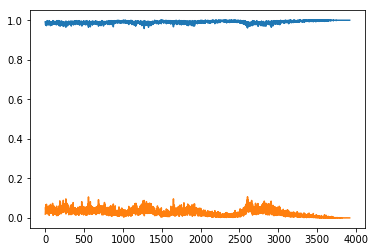

In [15]:
x = np.arange(0,len(accuracy))
plt.plot(x,np.array(accuracy),np.array(loss))
x = np.arange(0,len(validationacc))
plt.plot(x, np.array(validationacc))

In [16]:
t = time.time()
valacc = validateFunc(resnet, 100)
print(f"{time.time()-t:2.4f}\nacc {np.mean(valacc):.7f}")

6.0831
acc 0.8143727


#### DenseNet

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [11]:
if cuda_available:
    images = images.cpu()
imshow(torchvision.utils.make_grid(images))

NameError: name 'images' is not defined

In [ ]:
densenet = models.densenet161()